# Evaluating small community imitation games

In the previous notebook, `4_adding_small_communities.ipynb`, we implemented the classes needed to run the community based agent games.
We extracted these classes to the `communityImitationGameClasses.py` file.
We will now use these classes to evaluate the found results so that they can be compared to de Boer (2000).

**Reference**: de Boer, B. (2000). Self-organization in vowel systems. *In Journal of Phonetics (Vol. 28, Issue 4, pp. 441–465)*. Elsevier BV. https://doi.org/10.1006/jpho.2000.0125

<hr>
<hr>

## Table of contents

- Student information
- Required imports
- Emergence of a vowel system
- Evaluation of the emerged vowel system
- Sensitivity to parameter changes
   - Acoustic noise impact
   - Effective second formant weight impact
   - Population size impact

<hr>
<hr>

## Student information

- **Name**: Bontinck Lennert
- **Student ID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

<hr>
<hr>

## Required imports

Below we import the required things for this notebook.

In [9]:
# Import imitation game classes made in the previous notebook
from communityImitationGameClasses import Synthesizer, BarkOperator, CommunityGameEngine, CommunityRole, CommunityBehaviour;

# Used for saving and loading variables
import pickle;

# Used for easier numerical operations
import numpy as np;
import math

<hr>
<hr>

## Setting up the network

The below parameters will form the basis of the network structure used.

In [10]:
# Bark operator as used in de Boer (2000)
bark_operator = BarkOperator(critical_distance = 3.5, second_formant_weight = 0.3);

# Community configuration
community_member_amounts = {
    CommunityRole.BABY: 7,
    CommunityRole.DOCTORATE: 2,
    CommunityRole.PROFESSOR: 2,
    CommunityRole.PARENT: 5,
    CommunityRole.GRANDPARENT: 5,
    }

# Community behaviour 
community_behaviours = {
    CommunityRole.BABY: CommunityBehaviour(
      new_sound_prob = 0.03,
      synthesizer = Synthesizer(max_noise_ambient = 0.1, max_noise_agent=0.05),
      phoneme_step_size = 0.2,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT],
      influence_dictionary = {
        CommunityRole.BABY: 1,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTORATE: 1,
        CommunityRole.PROFESSOR: 1,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.STUDENT: CommunityBehaviour(
      new_sound_prob = 0.02,
      synthesizer = Synthesizer(max_noise_ambient = 0.1, max_noise_agent=0.02),
      phoneme_step_size = 0.1,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT, CommunityRole.STUDENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.DOCTORATE: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.075),
      phoneme_step_size = 0.0125,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.DOCTORATE, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PROFESSOR: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.075),
      phoneme_step_size = 0.0125,
      influential_agent_types = [CommunityRole.PROFESSOR, CommunityRole.DOCTORATE],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 4,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 0,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PARENT: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.025,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.PARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
                                                 
    CommunityRole.GRANDPARENT: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.025,
      influential_agent_types = [CommunityRole.GRANDPARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTORATE: 2,
        CommunityRole.PROFESSOR: 10,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
    }

<hr>
<hr>

## Emergence of a vowel system

Below we will study the emergence of a vowel system for a single simulation.

### Emergence from generation

We first test a scenario where there are 2 generations of agents to test an environment where agents are born and killed between iterations. All new agents start from an empty vowel repertoire.

In [11]:
if False: # Use saved result per default
    # Configuring game engine
    category_age_width = 4004 # > 4000 for plotting reasons (i.e. not a new generation of babies on plot)
    iterations = 8000
    
    
    community_game_engine = CommunityGameEngine(community_member_amounts = community_member_amounts,
                                            community_behaviours = community_behaviours,
                                            category_age_width = category_age_width,
                                            iterations = iterations,
                                            bark_operator = bark_operator);

    # Play the game the community game engine was configured for
    checkpoints = [20, 500, 2000, 4000, 6000, 8000];
    game_states = community_game_engine.play_imitation_game(checkpoints);

    # Store result to file
    with open("saved_variables/5/5-sample_game_generations.pickle", 'wb') as f:
        pickle.dump(game_states, f);


    # Delete unused variables
    del category_age_width;
    del iterations;
    del community_game_engine;
    del checkpoints;
    del game_states;
    del f;

In [12]:
# Get saved experiment result from file
with open("saved_variables/5/5-sample_game_generations.pickle", 'rb') as f:
    game_states = pickle.load(f);

# Delete unused variables
del f;

#### Plotting the results

Having played a sample game we plot the found results here.

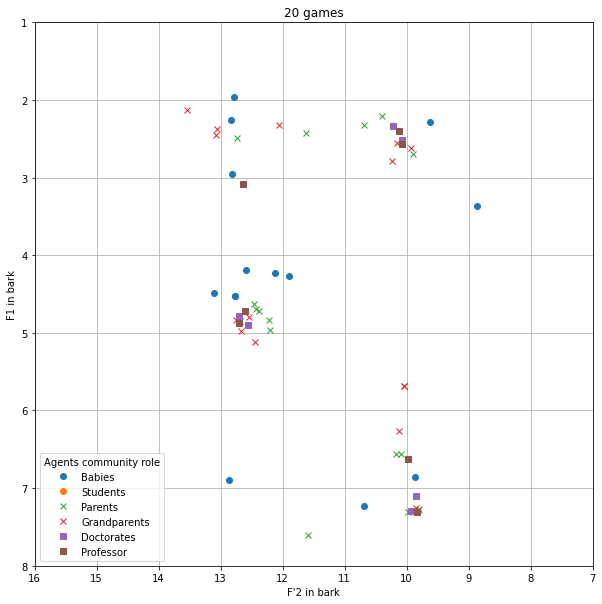

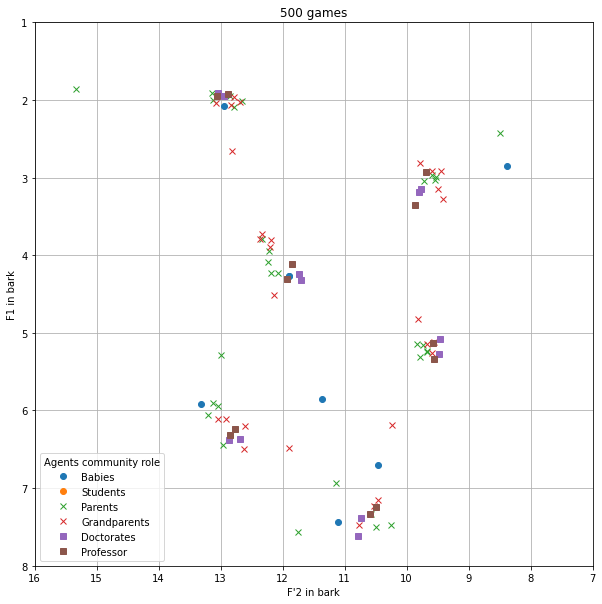

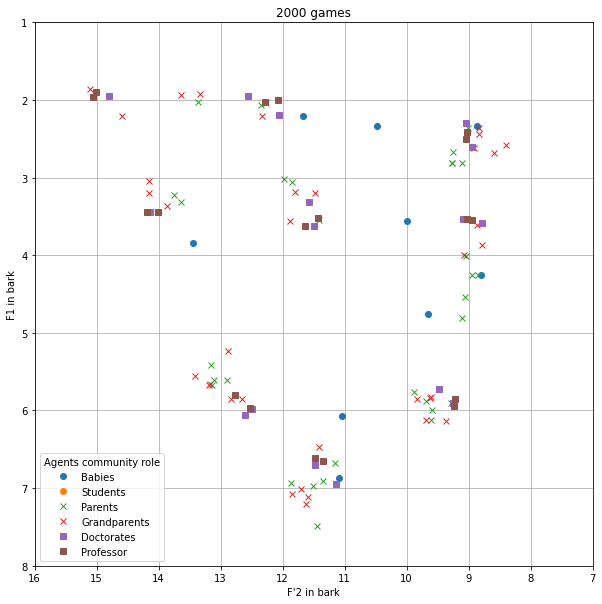

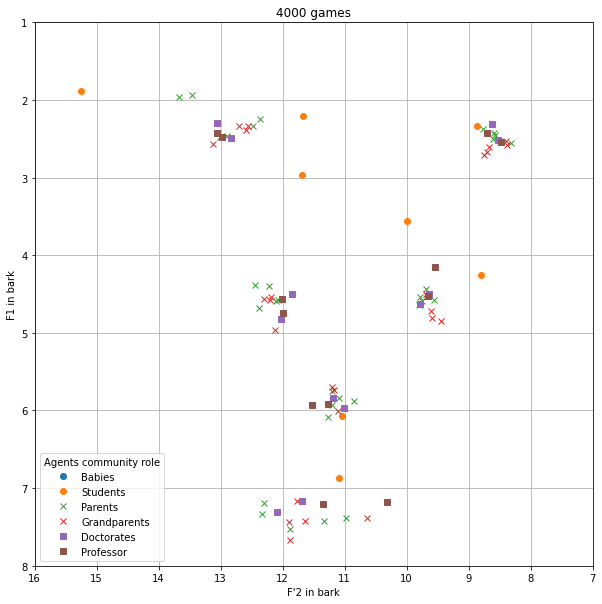

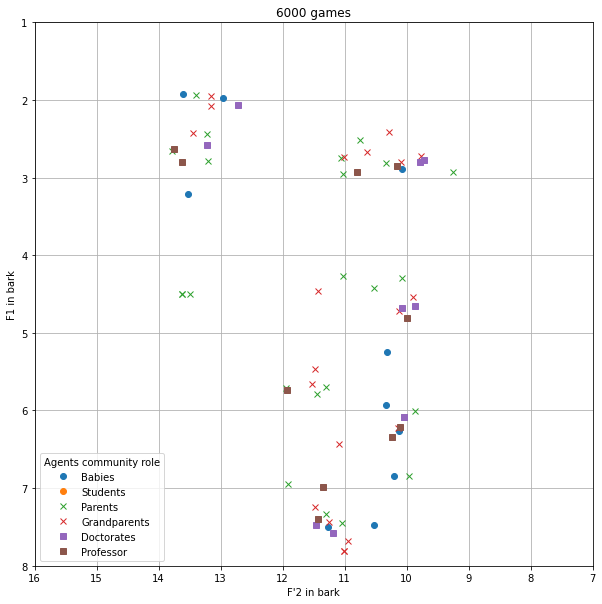

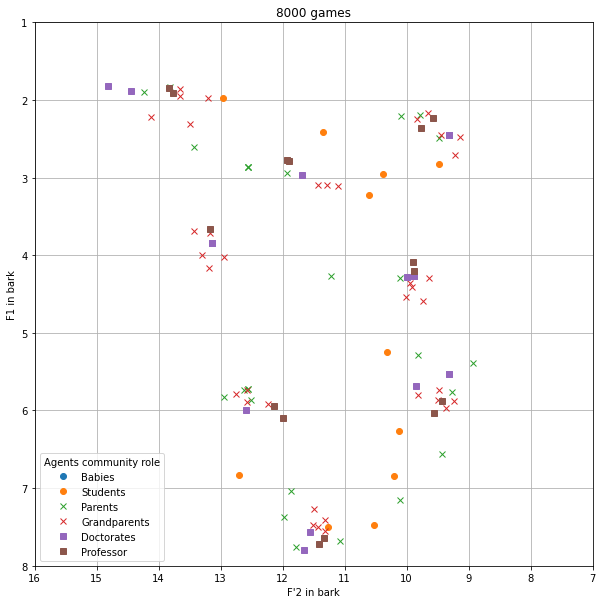

In [13]:
for game_state in game_states:
    game_state.plot();

# Delete unused variables
del game_state

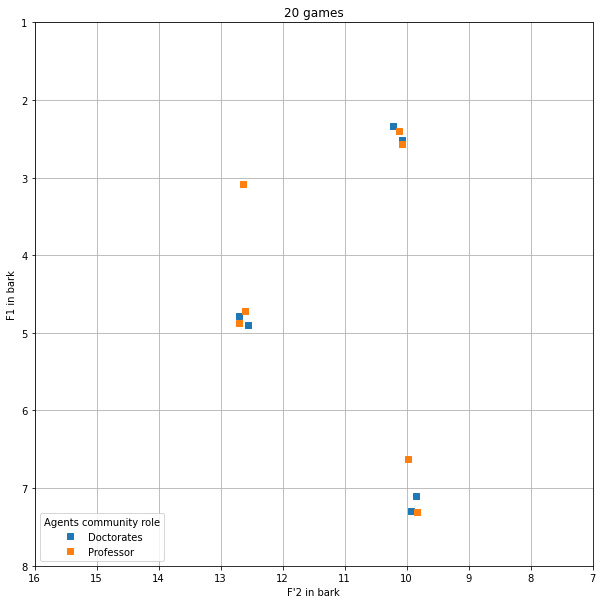

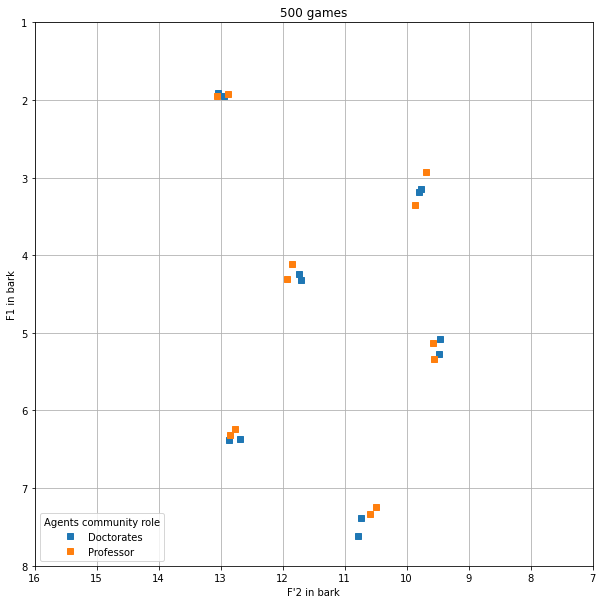

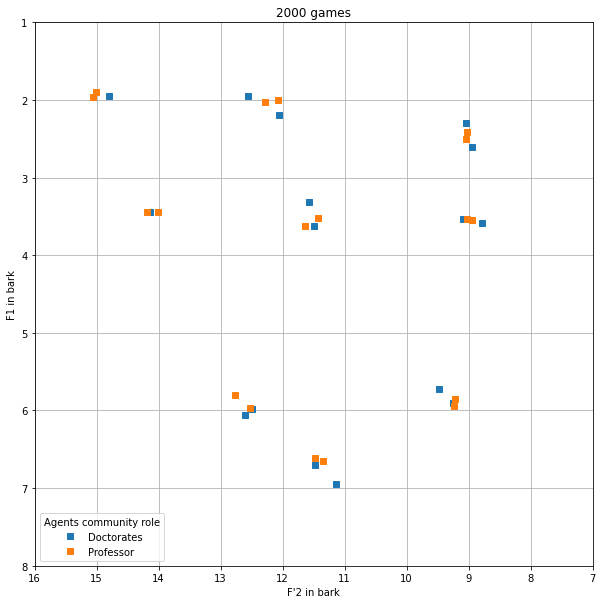

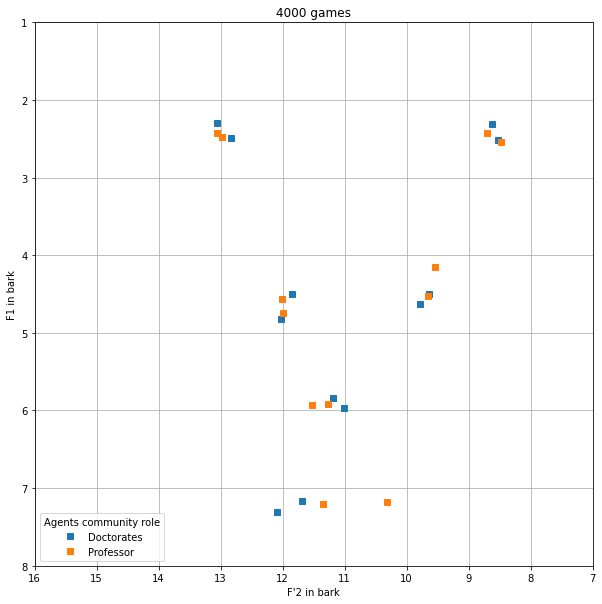

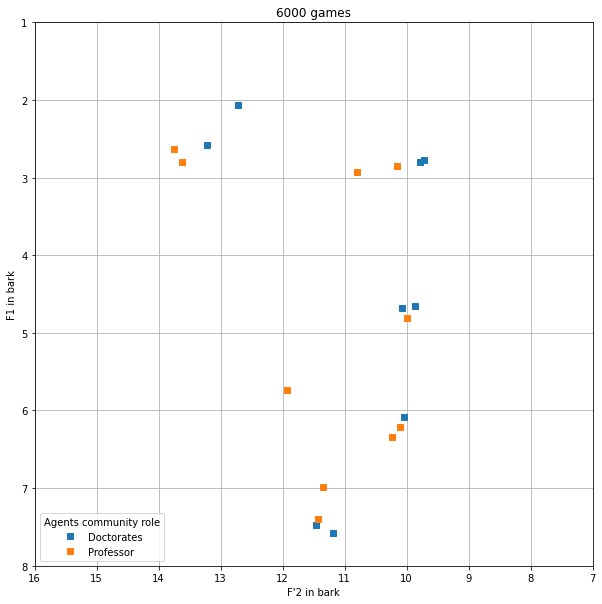

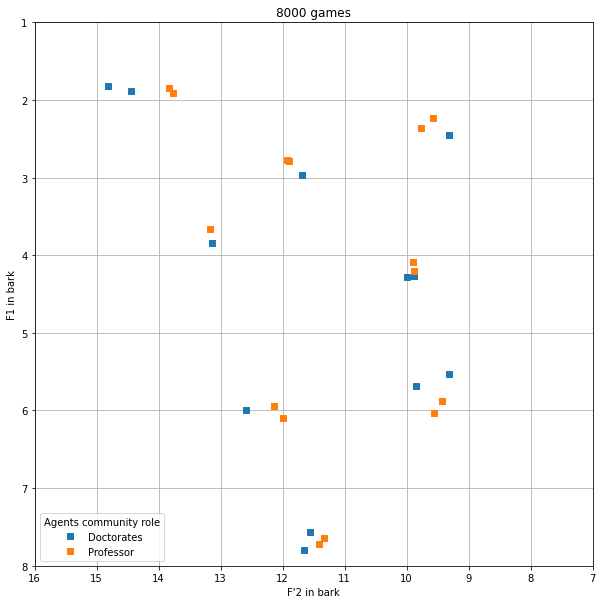

In [14]:
for game_state in game_states:
    game_state.plot_highly_schooled();

# Delete unused variables
del game_state

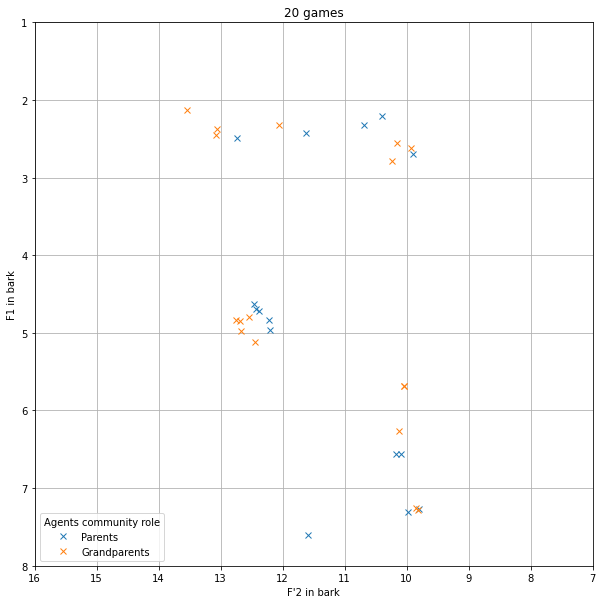

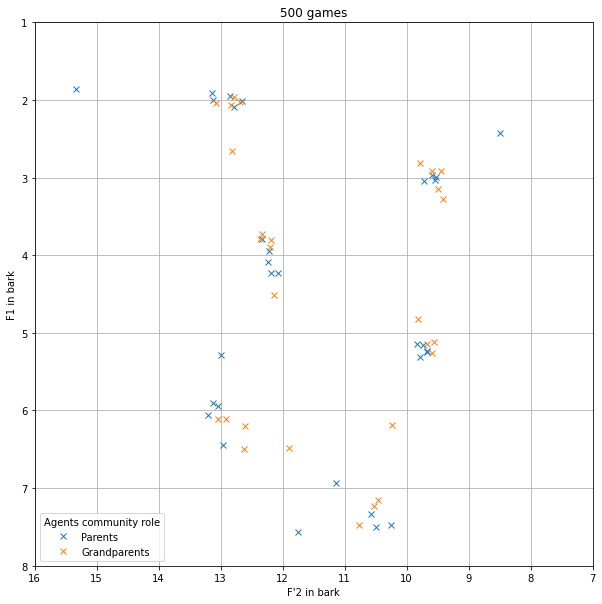

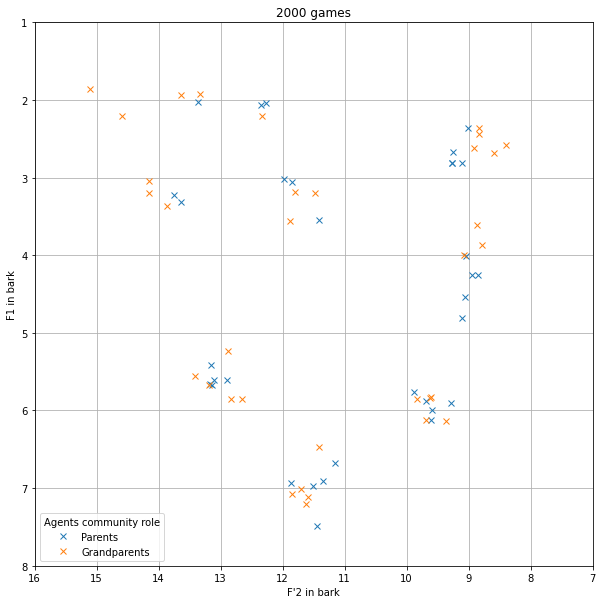

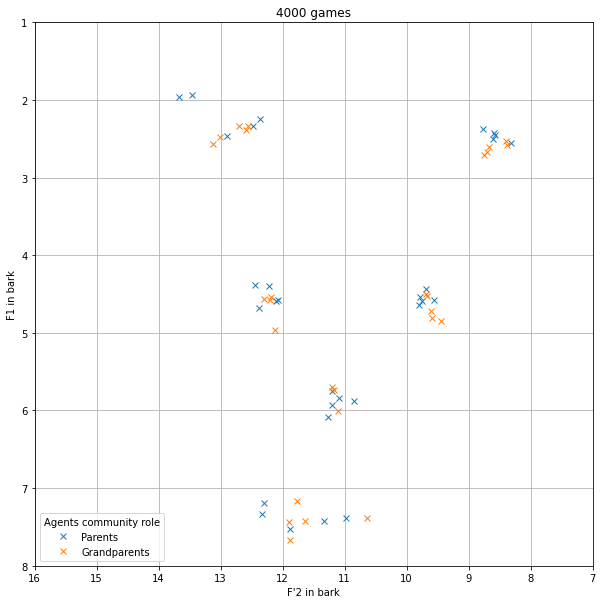

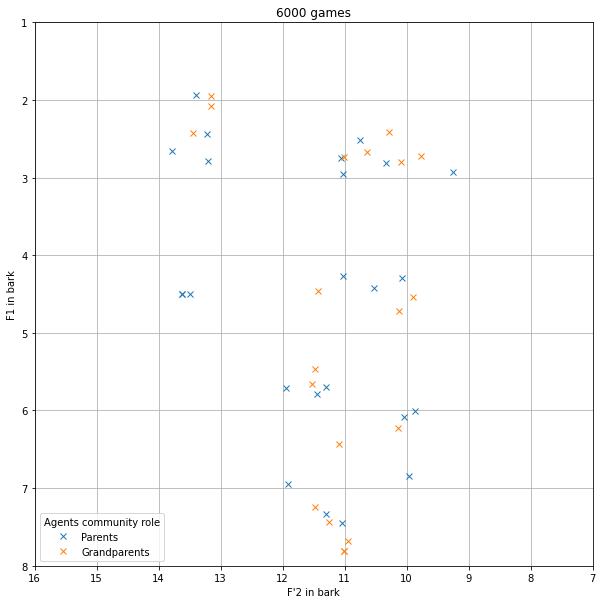

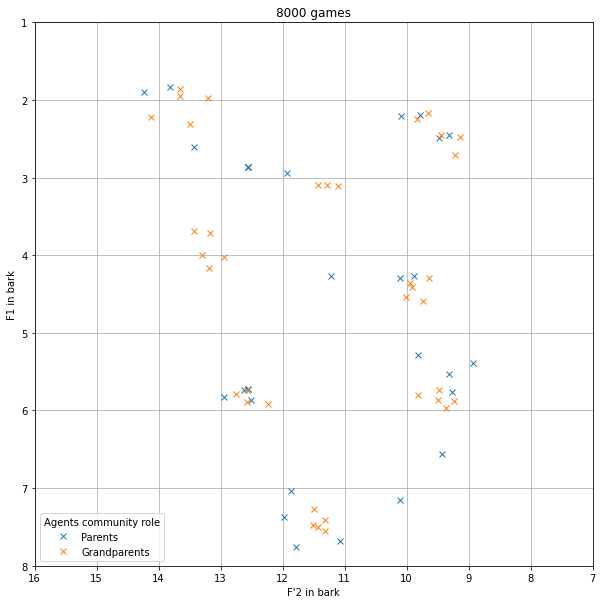

In [15]:
for game_state in game_states:
    game_state.plot_regular_schooled();

# Delete unused variables
del game_state

#### Discussing the results

TODO

In [16]:
# Delete unused variables
del game_states